What can we use to determine if a galaxy is a dwarf galaxy or not *before* fitting the TFR?

In [1]:
import numpy as np

from astropy.table import Table

import matplotlib.pyplot as plt

In [13]:
c = 3e5 # km/s

h = 1
H0 = 100*h # km/s/Mpc

q0 = 0.2

# Data

## fuji

We are going to use the table of galaxies for which we've already calculated the rotational velocities.

In [3]:
tfuji = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/SGA-2020_fuji_Vrot.fits')
tfuji[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p33R26,V_0p33R26_err
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64
896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.0062183426,0.0057331356,0.0059468574,0.0059097866,0.005547482,0.0057424223,0.005712396,0.005370375,0.0055686547,0.005550764,0.0052407323,0.0054267743,0.0054291883,0.0051505533,0.005328927,0.005367155,0.005074676,0.005267603,0.0053163357,16.432898,0.27237165,3.4572394,5.399334,1.6520585,15.889806,0.2892297,2.7702796,4.85128,0.7334321,15.531683,0.31152296,2.403034,4.429238,0.75814104,0,0.0224279674032048,2.44404472261522e-05,65.28941302448953,11.227243824610715
1548,SGA-2020 1548,SDSSJ1

## SGA

In [6]:
SGA = Table.read('../../data/SGA-2020_ALFALFA.fits')

SGA['ALFALFA_index'].name = 'ALFALFA_AGCNr'

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,ALFALFA_AGCNr
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int64
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0,-1
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.544437500000

In [7]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## ALFALFA

In [9]:
ALFALFA = Table.read('../../data/a100.code12.table2.190808.txt', 
                     format='ascii.csv', 
                     include_names=['AGCNr', 'W50', 'sigW', 'W20'])
ALFALFA[:5]

AGCNr,W50,sigW,W20
int64,int64,int64,int64
105367,274,39,281
333313,313,20,333
331060,160,4,184
331061,260,45,268
104570,245,6,250


In [10]:
ALFALFA_dict = {}

for i in range(len(ALFALFA)):
    
    ALFALFA_dict[ALFALFA['AGCNr'][i]] = i

# For SGA galaxies with rotational velocities, set the HI velocity of that galaxy

In [11]:
tfuji['V_HI'] = np.nan
tfuji['VERR_HI'] = np.nan
tfuji['V20_HI'] = np.nan

for i in range(len(tfuji)):
    
    # Find the row in the SGA for this galaxy
    SGA_idx = SGA_dict[tfuji['SGA_ID'][i]]
    
    # Set the HI velocity width of this galaxy
    if SGA['ALFALFA_AGCNr'][SGA_idx] >= 0:
        
        ALFALFA_idx = ALFALFA_dict[SGA['ALFALFA_AGCNr'][SGA_idx]]
        
        tfuji['V_HI'][i] = ALFALFA['W50'][ALFALFA_idx] - 6. # Adjustment from Kourkchi et al. (2020a), Sec. 2.2
        tfuji['VERR_HI'][i] = ALFALFA['sigW'][ALFALFA_idx]
        tfuji['V20_HI'][i] = ALFALFA['W20'][ALFALFA_idx]

## Correct the HI velocities for the inclination angle

In [16]:
tfuji['cosi2'] = (tfuji['BA']**2 - q0**2)/(1 - q0**2)
tfuji['cosi2'][tfuji['cosi2'] < 0] = 0

tfuji['V_HI_corr'] = tfuji['V_HI']/np.sin(np.arccos(np.sqrt(tfuji['cosi2'])))
tfuji['VERR_HI_corr'] = tfuji['VERR_HI']/np.sin(np.arccos(np.sqrt(tfuji['cosi2'])))

tfuji['V20_HI_corr'] = tfuji['V20_HI']/np.sin(np.arccos(np.sqrt(tfuji['cosi2'])))

# Calculate absolute magnitudes from the redshift

This will give us a general idea of which galaxies are dwarfs.

In [14]:
d = c*tfuji['Z_DESI']/H0*1e6 # pc
d_err = c*tfuji['ZERR_DESI']/H0*1e6 # pc

tfuji['R_ABSMAG_SB26_z'] = tfuji['R_MAG_SB26'] - 5*np.log10(d/10.)
tfuji['R_ABSMAG_SB26_z_err'] = np.sqrt(tfuji['R_MAG_SB26_ERR']**2 + (5/np.log(10))**2 * (d_err/d)**2)

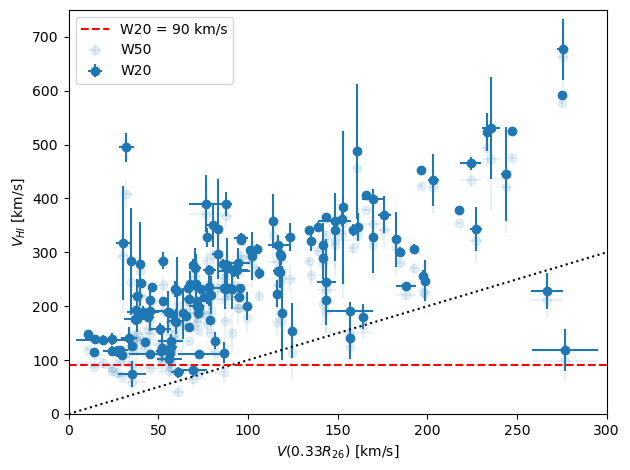

In [21]:
plt.figure(tight_layout=True)

plt.errorbar(tfuji['V_0p33R26'], tfuji['V_HI_corr'], 
             xerr=tfuji['V_0p33R26_err'], 
             yerr=tfuji['VERR_HI_corr'], 
             fmt='o', 
             alpha=0.1, 
             label='W50')
plt.errorbar(tfuji['V_0p33R26'], tfuji['V20_HI_corr'], 
             xerr=tfuji['V_0p33R26_err'], 
             yerr=tfuji['VERR_HI_corr'], 
             fmt='o', 
             c='tab:blue', 
             label='W20')

plt.plot([0, 800], [0, 800], 'k:')

plt.hlines(90, 0, 300, colors='r', linestyles='dashed', label='W20 = 90 km/s')

plt.xlim([0, 300])
plt.ylim([0, 750])

plt.legend()

plt.xlabel('$V(0.33R_{26})$ [km/s]')
plt.ylabel('$V_{HI}$ [km/s]');

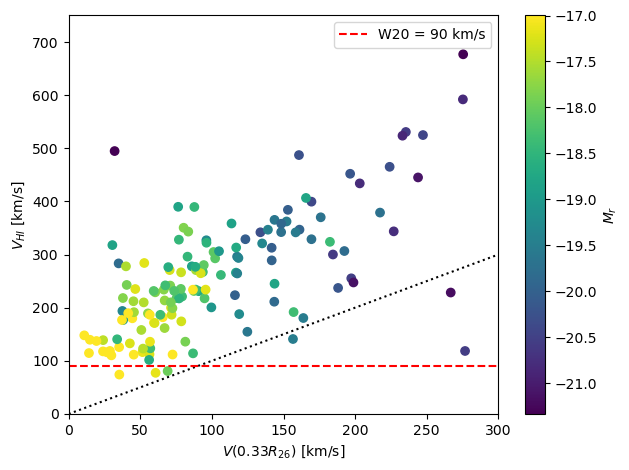

In [20]:
plt.figure(tight_layout=True)

plt.scatter(tfuji['V_0p33R26'], tfuji['V20_HI_corr'], 
            c=tfuji['R_ABSMAG_SB26_z'], 
            vmax=-17)
plt.colorbar(label='$M_r$')

plt.plot([0, 800], [0, 800], 'k:')

plt.hlines(90, 0, 300, colors='r', linestyles='dashed', label='W20 = 90 km/s')

plt.xlim([0, 300])
plt.ylim([0, 750])

plt.legend()

plt.xlabel('$V(0.33R_{26})$ [km/s]')
plt.ylabel('$V_{HI}$ [km/s]');